In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.backends.backend_pdf import PdfPages
from scipy.interpolate import UnivariateSpline
import os
import cv2
import glob

## 9 Parameters

Perform Fitting and Save Results

In [2]:
def fit9_and_save_results(file, T, indices, starting_column):
    data = pd.read_csv(f"{file}_ref.csv")
    csv_output_path = f"9_Parameters_{file}_results.csv"

    # Define the double Gaussian function
    def f_func(T, C1, C2, C3, C4, C5, C6, C7, C8, C9):
        return (C1 * np.exp(-C2 * T) + C3 +
                C4 * np.exp(-((T - C5) / C6)**2) +
                C7 * np.exp(-((T - C8) / C9)**2))

    # Initialize variables
    fitted_parameters = []
    r_squared_values = []
    peeq_values = []

    # Perform fitting for each row
    for j, i in enumerate(indices):
        if i != 0:
            stress = data.iloc[i, starting_column:].values
            #initial_guess = [1, 0.001, 0.5, 1, 300, 100, 1, 300, 100]
            #bounds = ([0, 0.00001, 0, 0, 200, 50, 0, 400, 50], [10, 0.01, 10, 5, 400, 200, 5, 700, 200])
            initial_guess = [1, 0.001, 0.5, 0.5, 300, 100, 0.5, 500, 100]
            bounds = ([0, 0.00001, 0, 0, 200, 50, 0, 400, 50], [10, 0.01, 10, 5, 400, 200, 5, 700, 200])
            #initial_guess = [1, 0.005, 0.7, 0.2, 550, 140, 0.2, 550, 140]
            #bounds = ([0, 0.00001, 0, 0, 200, 50, 0, 400, 50], [10, 1, 10, 5, 700, 500, 5, 700, 200])
            
            # Perform curve fitting
            params, _ = curve_fit(f_func, T, stress, p0=initial_guess, bounds=bounds, maxfev=100000)
            residuals = stress - f_func(T, *params)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((stress - np.mean(stress))**2)
            r_squared = 1 - (ss_res / ss_tot)

            # Save results
            fitted_parameters.append([data.iloc[i, 0], *params, r_squared])
            r_squared_values.append(r_squared)
            peeq_values.append(data.iloc[i, 0])

    # Save all results to CSV
    columns = ['PEEQ', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'R²']
    fitted_parameters_df = pd.DataFrame(fitted_parameters, columns=columns)
    fitted_parameters_df.to_csv(csv_output_path, index=False)
    print(f"Fitting results saved to '{csv_output_path}'")
    
    # Calculate R² statistics
    min_r2 = min(r_squared_values)
    max_r2 = max(r_squared_values)
    avg_r2 = np.mean(r_squared_values)
    peeq_min_r2 = peeq_values[r_squared_values.index(min_r2)]
    peeq_max_r2 = peeq_values[r_squared_values.index(max_r2)]
    # Calculate percentage of R² values below 0.95
    below = sum(1 for r2 in r_squared_values if r2 < 0.99)
    percentage_below = (below / len(r_squared_values)) * 100

    # Print R² statistics
    print("\nR² Statistics:")
    print(f"Smallest R²: {min_r2:.3f} (PEEQ: {peeq_min_r2:.5f})")
    print(f"Largest R²: {max_r2:.3f} (PEEQ: {peeq_max_r2:.5f})")
    print(f"Average R²: {avg_r2:.3f}")
    print(f"Percentage of R² values below 0.99: {percentage_below:.2f}%")

Generate PDF and Excel

In [3]:
def generate_pdf_with_original_and_fitted_data(file, T, starting_column):
    # Read the results from the saved CSV file
    results = pd.read_csv(f"9_Parameters_{file}_results.csv")
    original_data = pd.read_csv(f"{file}_ref.csv").iloc[1:]
    output_pdf = f"9_Parameters_{file}_final.pdf"
    output_images_dir = "plots"

    # Create directory for plots
    os.makedirs(output_images_dir, exist_ok=True)

    # Initialize a PDF for storing plots
    pdf_pages = PdfPages(output_pdf)

    # Loop through the results to generate plots
    for index, row in results.iterrows():
        peeq = row['PEEQ']  # Extract PEEQ
        params = row[1:-1].values  # Extract parameters C1 to C9
        r_squared = row['R²']  # Extract R² value

        # Extract the original data
        stress_original = original_data.iloc[index, starting_column:].values

        # Generate data for the fitted curve
        T_fit = np.linspace(np.min(T), np.max(T), 100)
        stress_fit = (
            params[0] * np.exp(-params[1] * T_fit) + params[2] +
            params[3] * np.exp(-((T_fit - params[4]) / params[5])**2) +
            params[6] * np.exp(-((T_fit - params[7]) / params[8])**2)
        )

        # Plot both original data and fitted curve
        plt.figure()
        plt.ylim(0.8, 2.4) #0.0001 and 0.01
        #plt.ylim(0.8, 1.5) #0.001 and 0.1
        plt.plot(T, stress_original, 'o', label='Data')  # Plot original data
        plt.plot(T_fit, stress_fit, '-', label='Fitted Curve')  # Plot fitted curve
        plt.xlabel('Temperature (K)')
        plt.ylabel('Normalized Stress')
        plt.title(f"Strain={peeq:.5f} (R² = {r_squared:.3f})", fontweight='bold')
        plt.legend([
            f'Data',
            f'Fit: C1={params[0]:.3f}, C2={params[1]:.3f}, C3={params[2]:.3f},\n'
            f'C4={params[3]:.3f}, C5={params[4]:.3f}, C6={params[5]:.3f},\n'
            f'C7={params[6]:.3f}, C8={params[7]:.3f}, C9={params[8]:.3f}'
        ])
        
        # Save the current figure to the PDF
        pdf_pages.savefig()

        # Save the current figure as an image for video generation
        image_path = os.path.join(output_images_dir, f"plot_{index:03d}.png")
        plt.savefig(image_path, dpi=300)  # High resolution
        plt.close()

    # Close the PDF file
    pdf_pages.close()
    print(f"PDF with original data and fitted curves saved as '{output_pdf}'")
    print(f"Plots saved in '{output_images_dir}'")

Generate video

In [4]:
def generate_video_from_plots(file, step=4):
    """
    Generate a video from the saved plot images, using every nth plot (default step=4).
    
    Args:
        file (str): The base name of the file for plots and video.
        step (int): The step size to include every nth plot in the video.
    """
    output_images_dir = "plots"
    output_video_path = f"9_Parameters_{file}_final_step_{step}.mp4"

    # Get the list of image files
    image_files = sorted(glob.glob(os.path.join(output_images_dir, "plot_*.png")))

    # Filter to include only every `step` plot
    selected_images = image_files[::step]

    # Check if there are any images
    if not selected_images:
        print("No images found in the plots directory. Please run the PDF generation first.")
        return

    # Read the first image to get dimensions
    frame = cv2.imread(selected_images[0])
    height, width, layers = frame.shape

    # Define the video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # MP4 codec
    video = cv2.VideoWriter(output_video_path, fourcc, 3, (width, height))  # 2 FPS

    # Write each selected image to the video
    for image_file in selected_images:
        frame = cv2.imread(image_file)
        video.write(frame)

    video.release()
    print(f"Video saved as '{output_video_path}'")

In [6]:
file_0001 = 'Fitted_FC_TmpDpn_RD_StrRt0.0001'
#T = np.array([298.15, 373.15, 473.15, 573.15, 673.15]) #other strain-rates
T = np.array([77.15, 233.15, 298.15, 373.15, 473.15, 573.15, 673.15]) #0.0001
#indices = np.array([1,2,3, 4, 5, 6, 10,11,14,15,20,25,30,35,40,45,50,100,200,230,250,270,280,290,300,310])
indices = np.arange(0, 396)
#starting_column = 6 #other strain-rates
starting_column = 8 #0.0001

In [6]:
fit9_and_save_results(file_0001, T, indices, starting_column)

/opt/software/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Fitting results saved to '9_Parameters_Fitted_FC_TmpDpn_RD_StrRt0.0001_results.csv'

R² Statistics:
Smallest R²: 0.990 (PEEQ: 0.00011)
Largest R²: 1.000 (PEEQ: 0.00500)
Average R²: 1.000
Percentage of R² values below 0.99: 0.00%


In [7]:
def generate_pdf_with_original_and_fitted_data(file, T, starting_column):
    # Read the results from the saved CSV file
    results = pd.read_csv(f"9_Parameters_{file}_results.csv")
    original_data = pd.read_csv(f"{file}_ref.csv").iloc[1:]
    output_pdf = f"9_Parameters_{file}_final.pdf"
    output_images_dir = "plots"

    # Create directory for plots
    os.makedirs(output_images_dir, exist_ok=True)

    # Initialize a PDF for storing plots
    pdf_pages = PdfPages(output_pdf)

    # Loop through the results to generate plots
    for index, row in results.iterrows():
        peeq = row['PEEQ']  # Extract PEEQ
        params = row[1:-1].values  # Extract parameters C1 to C9
        r_squared = row['R²']  # Extract R² value

        # Extract the original data
        stress_original = original_data.iloc[index, starting_column:].values

        # Generate data for the fitted curve
        T_fit = np.linspace(np.min(T), np.max(T), 100)
        stress_fit = (
            params[0] * np.exp(-params[1] * T_fit) + params[2] +
            params[3] * np.exp(-((T_fit - params[4]) / params[5])**2) +
            params[6] * np.exp(-((T_fit - params[7]) / params[8])**2)
        )

        # Plot both original data and fitted curve
        plt.figure()
        plt.ylim(0.8, 2.4) #0.0001 and 0.01
        #plt.ylim(0.8, 1.5) #0.001 and 0.1
        plt.plot(T, stress_original, 'o', label='Data')  # Plot original data
        plt.plot(T_fit, stress_fit, '-', label='Fitted Curve')  # Plot fitted curve
        plt.xlabel('Temperature (K)')
        plt.ylabel('Normalized Stress')
        plt.title(f"Strain={peeq:.5f} (R² = {r_squared:.3f})", fontweight='bold')
        plt.legend([
            f'Data',
            f'Fit: C1={params[0]:.3f}, C2={params[1]:.3f}, C3={params[2]:.3f},\n'
            f'C4={params[3]:.3f}, C5={params[4]:.3f}, C6={params[5]:.3f},\n'
            f'C7={params[6]:.3f}, C8={params[7]:.3f}, C9={params[8]:.3f}'
        ])
        
        # Save the current figure to the PDF
        pdf_pages.savefig()

        # Save the current figure as an image for video generation
        image_path = os.path.join(output_images_dir, f"plot_{index:03d}.png")
        plt.savefig(image_path, dpi=300)  # High resolution
        plt.close()

    # Close the PDF file
    pdf_pages.close()
    print(f"PDF with original data and fitted curves saved as '{output_pdf}'")
    print(f"Plots saved in '{output_images_dir}'")
generate_pdf_with_original_and_fitted_data(file_0001, T, starting_column)

PDF with original data and fitted curves saved as '9_Parameters_Fitted_FC_TmpDpn_RD_StrRt0.0001_final.pdf'
Plots saved in 'plots'


In [8]:
generate_video_from_plots(file_0001, step=6)

Video saved as '9_Parameters_Fitted_FC_TmpDpn_RD_StrRt0.0001_final_step_6.mp4'


0.001

In [9]:
file_001 = 'Fitted_FC_TmpDpn_RD_StrRt0.001'
T = np.array([298.15, 373.15, 473.15, 573.15, 673.15]) #other strain-rates
#T = np.array([77.15, 233.15, 298.15, 373.15, 473.15, 573.15, 673.15]) #0.0001
#indices = np.array([1,2,3, 4, 5, 6, 10,11,14,15,20,25,30,35,40,45,50,100,200,230,250,270,280,290,300,310])
indices = np.arange(0, 396)
starting_column = 6 #other strain-rates
#starting_column = 8 #0.0001

In [10]:
fit9_and_save_results(file_001, T, indices, starting_column)

/opt/software/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Fitting results saved to '9_Parameters_Fitted_FC_TmpDpn_RD_StrRt0.001_results.csv'

R² Statistics:
Smallest R²: 0.483 (PEEQ: 0.00011)
Largest R²: 1.000 (PEEQ: 0.00070)
Average R²: 0.998
Percentage of R² values below 0.99: 0.76%


In [11]:
def generate_pdf_with_original_and_fitted_data(file, T, starting_column):
    # Read the results from the saved CSV file
    results = pd.read_csv(f"9_Parameters_{file}_results.csv")
    original_data = pd.read_csv(f"{file}_ref.csv").iloc[1:]
    output_pdf = f"9_Parameters_{file}_final.pdf"
    output_images_dir = "plots"

    # Create directory for plots
    os.makedirs(output_images_dir, exist_ok=True)

    # Initialize a PDF for storing plots
    pdf_pages = PdfPages(output_pdf)

    # Loop through the results to generate plots
    for index, row in results.iterrows():
        peeq = row['PEEQ']  # Extract PEEQ
        params = row[1:-1].values  # Extract parameters C1 to C9
        r_squared = row['R²']  # Extract R² value

        # Extract the original data
        stress_original = original_data.iloc[index, starting_column:].values

        # Generate data for the fitted curve
        T_fit = np.linspace(np.min(T), np.max(T), 100)
        stress_fit = (
            params[0] * np.exp(-params[1] * T_fit) + params[2] +
            params[3] * np.exp(-((T_fit - params[4]) / params[5])**2) +
            params[6] * np.exp(-((T_fit - params[7]) / params[8])**2)
        )

        # Plot both original data and fitted curve
        plt.figure()
        #plt.ylim(0.8, 2.4) #0.0001 and 0.01
        plt.ylim(0.8, 1.5) #0.001 and 0.1
        plt.plot(T, stress_original, 'o', label='Data')  # Plot original data
        plt.plot(T_fit, stress_fit, '-', label='Fitted Curve')  # Plot fitted curve
        plt.xlabel('Temperature (K)')
        plt.ylabel('Normalized Stress')
        plt.title(f"Strain={peeq:.5f} (R² = {r_squared:.3f})", fontweight='bold')
        plt.legend([
            f'Data',
            f'Fit: C1={params[0]:.3f}, C2={params[1]:.3f}, C3={params[2]:.3f},\n'
            f'C4={params[3]:.3f}, C5={params[4]:.3f}, C6={params[5]:.3f},\n'
            f'C7={params[6]:.3f}, C8={params[7]:.3f}, C9={params[8]:.3f}'
        ])
        
        # Save the current figure to the PDF
        pdf_pages.savefig()

        # Save the current figure as an image for video generation
        image_path = os.path.join(output_images_dir, f"plot_{index:03d}.png")
        plt.savefig(image_path, dpi=300)  # High resolution
        plt.close()

    # Close the PDF file
    pdf_pages.close()
    print(f"PDF with original data and fitted curves saved as '{output_pdf}'")
    print(f"Plots saved in '{output_images_dir}'")
generate_pdf_with_original_and_fitted_data(file_001, T, starting_column)

PDF with original data and fitted curves saved as '9_Parameters_Fitted_FC_TmpDpn_RD_StrRt0.001_final.pdf'
Plots saved in 'plots'


In [12]:
generate_video_from_plots(file_001, step=6)

Video saved as '9_Parameters_Fitted_FC_TmpDpn_RD_StrRt0.001_final_step_6.mp4'


0.01

In [13]:
file_01 = 'Fitted_FC_TmpDpn_RD_StrRt0.01'
T = np.array([298.15, 373.15, 473.15, 573.15, 673.15]) #other strain-rates
#T = np.array([77.15, 233.15, 298.15, 373.15, 473.15, 573.15, 673.15]) #0.0001
#indices = np.array([1,2,3, 4, 5, 6, 10,11,14,15,20,25,30,35,40,45,50,100,200,230,250,270,280,290,300,310])
indices = np.arange(0, 396)
starting_column = 6 #other strain-rates
#starting_column = 8 #0.0001

In [14]:
fit9_and_save_results(file_01, T, indices, starting_column)

/opt/software/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Fitting results saved to '9_Parameters_Fitted_FC_TmpDpn_RD_StrRt0.01_results.csv'

R² Statistics:
Smallest R²: 0.975 (PEEQ: 2.89000)
Largest R²: 1.000 (PEEQ: 0.00011)
Average R²: 0.999
Percentage of R² values below 0.99: 2.53%


In [15]:
def generate_pdf_with_original_and_fitted_data(file, T, starting_column):
    # Read the results from the saved CSV file
    results = pd.read_csv(f"9_Parameters_{file}_results.csv")
    original_data = pd.read_csv(f"{file}_ref.csv").iloc[1:]
    output_pdf = f"9_Parameters_{file}_final.pdf"
    output_images_dir = "plots"

    # Create directory for plots
    os.makedirs(output_images_dir, exist_ok=True)

    # Initialize a PDF for storing plots
    pdf_pages = PdfPages(output_pdf)

    # Loop through the results to generate plots
    for index, row in results.iterrows():
        peeq = row['PEEQ']  # Extract PEEQ
        params = row[1:-1].values  # Extract parameters C1 to C9
        r_squared = row['R²']  # Extract R² value

        # Extract the original data
        stress_original = original_data.iloc[index, starting_column:].values

        # Generate data for the fitted curve
        T_fit = np.linspace(np.min(T), np.max(T), 100)
        stress_fit = (
            params[0] * np.exp(-params[1] * T_fit) + params[2] +
            params[3] * np.exp(-((T_fit - params[4]) / params[5])**2) +
            params[6] * np.exp(-((T_fit - params[7]) / params[8])**2)
        )

        # Plot both original data and fitted curve
        plt.figure()
        #plt.ylim(0.8, 2.4) #0.0001 and 0.01
        plt.ylim(0.8, 1.6) #0.001 and 0.1
        plt.plot(T, stress_original, 'o', label='Data')  # Plot original data
        plt.plot(T_fit, stress_fit, '-', label='Fitted Curve')  # Plot fitted curve
        plt.xlabel('Temperature (K)')
        plt.ylabel('Normalized Stress')
        plt.title(f"Strain={peeq:.5f} (R² = {r_squared:.3f})", fontweight='bold')
        plt.legend([
            f'Data',
            f'Fit: C1={params[0]:.3f}, C2={params[1]:.3f}, C3={params[2]:.3f},\n'
            f'C4={params[3]:.3f}, C5={params[4]:.3f}, C6={params[5]:.3f},\n'
            f'C7={params[6]:.3f}, C8={params[7]:.3f}, C9={params[8]:.3f}'
        ])
        
        # Save the current figure to the PDF
        pdf_pages.savefig()

        # Save the current figure as an image for video generation
        image_path = os.path.join(output_images_dir, f"plot_{index:03d}.png")
        plt.savefig(image_path, dpi=300)  # High resolution
        plt.close()

    # Close the PDF file
    pdf_pages.close()
    print(f"PDF with original data and fitted curves saved as '{output_pdf}'")
    print(f"Plots saved in '{output_images_dir}'")
generate_pdf_with_original_and_fitted_data(file_01, T, starting_column)

PDF with original data and fitted curves saved as '9_Parameters_Fitted_FC_TmpDpn_RD_StrRt0.01_final.pdf'
Plots saved in 'plots'


In [16]:
generate_video_from_plots(file_01, step=6)

Video saved as '9_Parameters_Fitted_FC_TmpDpn_RD_StrRt0.01_final_step_6.mp4'


In [17]:
file_1 = 'Fitted_FC_TmpDpn_RD_StrRt0.1'
T = np.array([298.15, 373.15, 473.15, 573.15, 673.15]) #other strain-rates
#T = np.array([77.15, 233.15, 298.15, 373.15, 473.15, 573.15, 673.15]) #0.0001
#indices = np.array([1,2,3, 4, 5, 6, 10,11,14,15,20,25,30,35,40,45,50,100,200,230,250,270,280,290,300,310])
indices = np.arange(0, 396)
starting_column = 6 #other strain-rates
#starting_column = 8 #0.0001

In [18]:
fit9_and_save_results(file_1, T, indices, starting_column)

/opt/software/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Fitting results saved to '9_Parameters_Fitted_FC_TmpDpn_RD_StrRt0.1_results.csv'

R² Statistics:
Smallest R²: 0.910 (PEEQ: 0.00080)
Largest R²: 1.000 (PEEQ: 0.00050)
Average R²: 1.000
Percentage of R² values below 0.99: 0.25%


In [19]:
def generate_pdf_with_original_and_fitted_data(file, T, starting_column):
    # Read the results from the saved CSV file
    results = pd.read_csv(f"9_Parameters_{file}_results.csv")
    original_data = pd.read_csv(f"{file}_ref.csv").iloc[1:]
    output_pdf = f"9_Parameters_{file}_final.pdf"
    output_images_dir = "plots"

    # Create directory for plots
    os.makedirs(output_images_dir, exist_ok=True)

    # Initialize a PDF for storing plots
    pdf_pages = PdfPages(output_pdf)

    # Loop through the results to generate plots
    for index, row in results.iterrows():
        peeq = row['PEEQ']  # Extract PEEQ
        params = row[1:-1].values  # Extract parameters C1 to C9
        r_squared = row['R²']  # Extract R² value

        # Extract the original data
        stress_original = original_data.iloc[index, starting_column:].values

        # Generate data for the fitted curve
        T_fit = np.linspace(np.min(T), np.max(T), 100)
        stress_fit = (
            params[0] * np.exp(-params[1] * T_fit) + params[2] +
            params[3] * np.exp(-((T_fit - params[4]) / params[5])**2) +
            params[6] * np.exp(-((T_fit - params[7]) / params[8])**2)
        )

        # Plot both original data and fitted curve
        plt.figure()
        #plt.ylim(0.8, 2.4) #0.0001 and 0.01
        plt.ylim(0.8, 1.6) #0.001 and 0.1
        plt.plot(T, stress_original, 'o', label='Data')  # Plot original data
        plt.plot(T_fit, stress_fit, '-', label='Fitted Curve')  # Plot fitted curve
        plt.xlabel('Temperature (K)')
        plt.ylabel('Normalized Stress')
        plt.title(f"Strain={peeq:.5f} (R² = {r_squared:.3f})", fontweight='bold')
        plt.legend([
            f'Data',
            f'Fit: C1={params[0]:.3f}, C2={params[1]:.3f}, C3={params[2]:.3f},\n'
            f'C4={params[3]:.3f}, C5={params[4]:.3f}, C6={params[5]:.3f},\n'
            f'C7={params[6]:.3f}, C8={params[7]:.3f}, C9={params[8]:.3f}'
        ])
        
        # Save the current figure to the PDF
        pdf_pages.savefig()

        # Save the current figure as an image for video generation
        image_path = os.path.join(output_images_dir, f"plot_{index:03d}.png")
        plt.savefig(image_path, dpi=300)  # High resolution
        plt.close()

    # Close the PDF file
    pdf_pages.close()
    print(f"PDF with original data and fitted curves saved as '{output_pdf}'")
    print(f"Plots saved in '{output_images_dir}'")
generate_pdf_with_original_and_fitted_data(file_1, T, starting_column)

PDF with original data and fitted curves saved as '9_Parameters_Fitted_FC_TmpDpn_RD_StrRt0.01_final.pdf'
Plots saved in 'plots'
PDF with original data and fitted curves saved as '9_Parameters_Fitted_FC_TmpDpn_RD_StrRt0.1_final.pdf'
Plots saved in 'plots'


In [20]:
generate_video_from_plots(file_1, step=6)

Video saved as '9_Parameters_Fitted_FC_TmpDpn_RD_StrRt0.1_final_step_6.mp4'


## Plot C-data

In [21]:
data = pd.read_csv(f"9_Parameters_{file_0001}_results.csv")

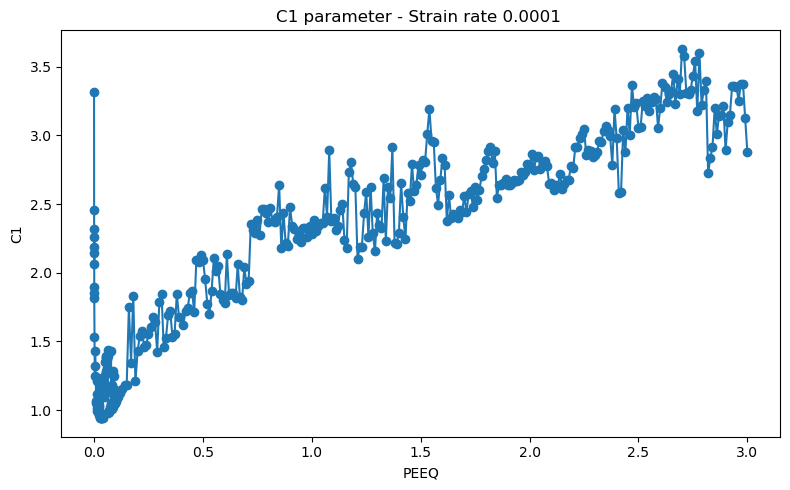

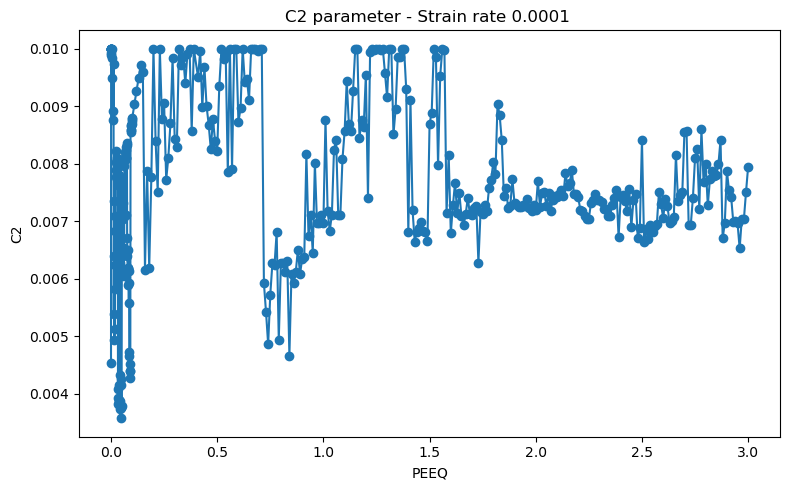

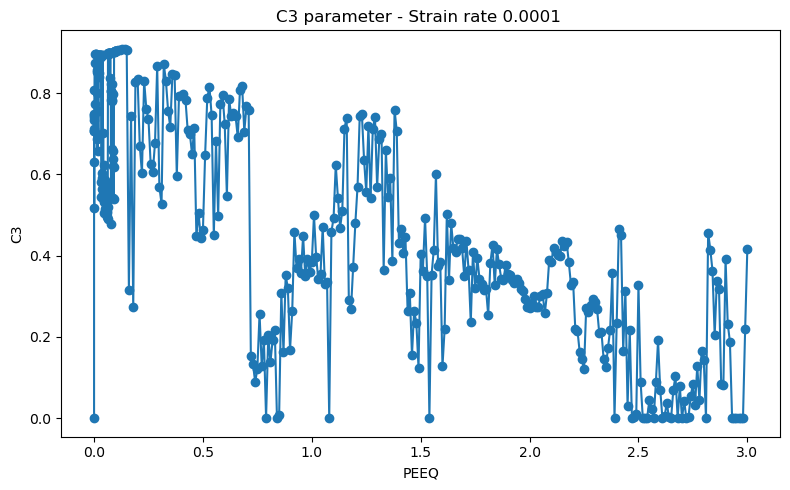

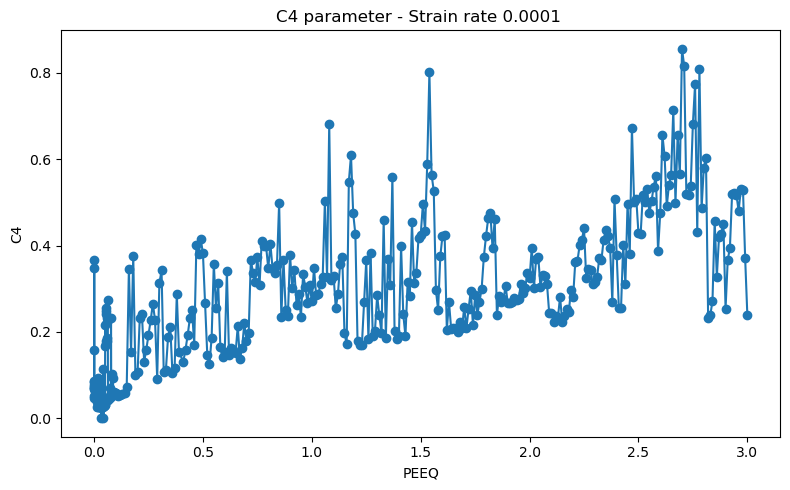

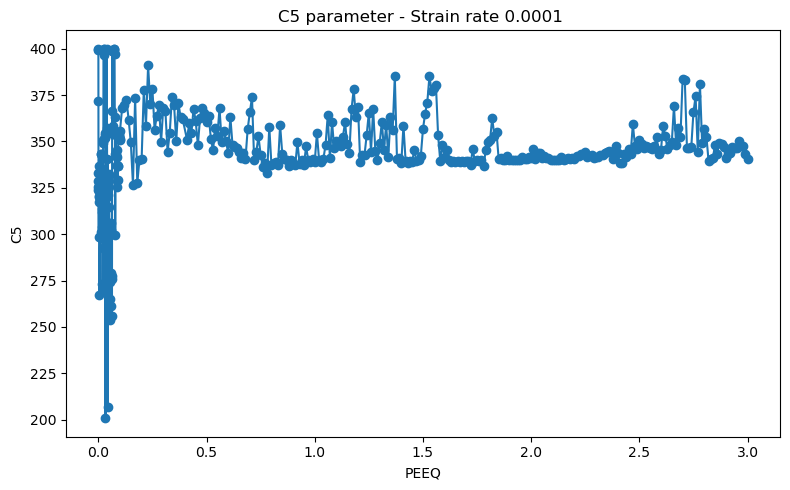

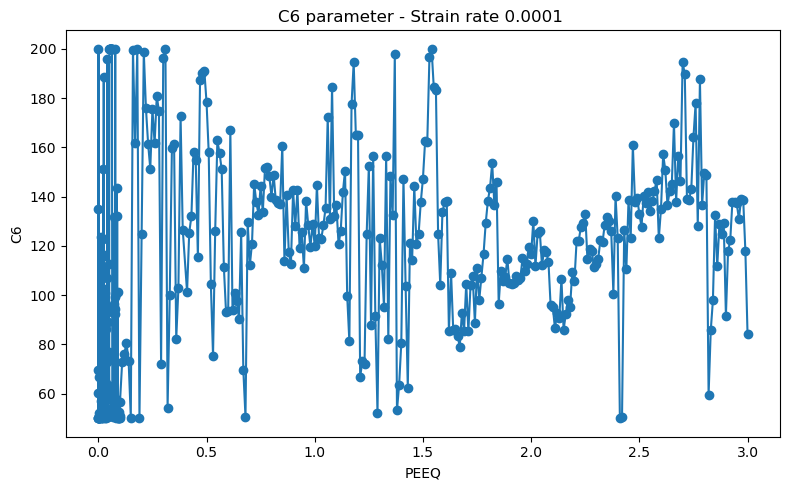

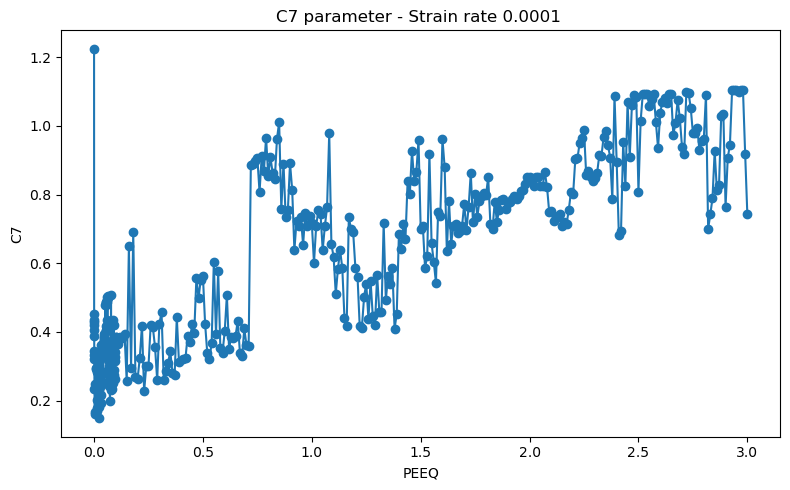

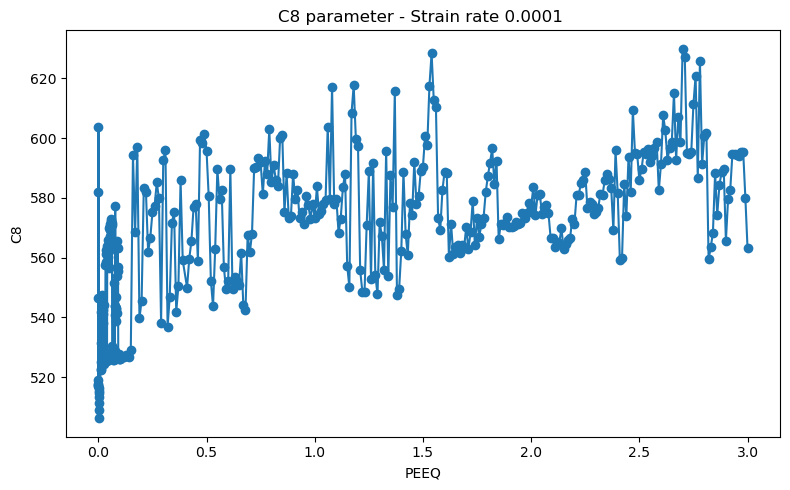

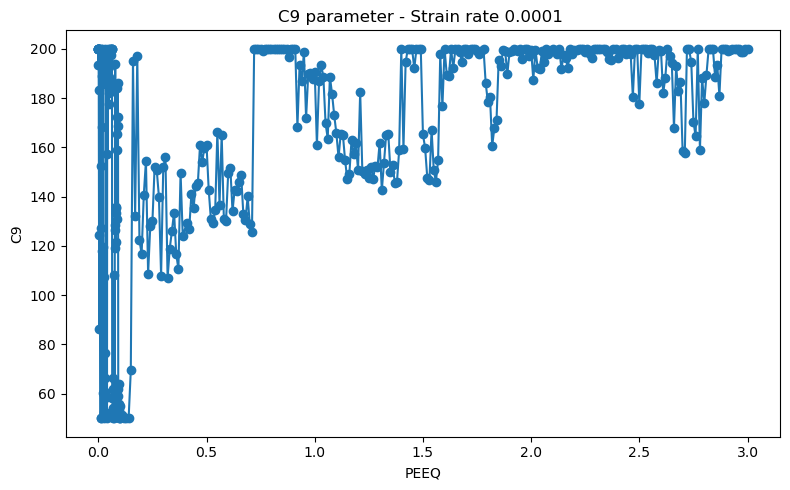

In [22]:
# Specify the column names
x_column = 'PEEQ'
y_columns = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6','C7','C8','C9']

# Specify the PEEQ bounds
peeq_lower_bound = 0
peeq_upper_bound = 3

# Filter data based on the PEEQ bounds
filtered_data = data[
    (data[x_column] > peeq_lower_bound) & 
    (data[x_column] <= peeq_upper_bound) & 
    (data[x_column] != 0.4)  # Exclude strain = 0.4
]

# Iterate over each y-column and create a plot
for y_column in y_columns:
    plt.figure(figsize=(8, 5))
    #plt.plot(filtered_data[x_column], filtered_data[y_column], marker='o', linestyle='-', label=y_column)
    plt.plot(filtered_data[x_column], filtered_data[y_column], marker='o', linestyle='-')
    plt.xlabel('PEEQ')
    plt.ylabel(y_column)
    plt.title(f'{y_column} parameter - Strain rate 0.0001 ')
    #plt.legend()
    #plt.grid(True)
    plt.tight_layout()
    plt.show()

## Plot all data

In [2]:
file_0001 = 'Fitted_FC_TmpDpn_RD_StrRt0.0001'
file_001 = 'Fitted_FC_TmpDpn_RD_StrRt0.001'
file_01 = 'Fitted_FC_TmpDpn_RD_StrRt0.01'
file_1 = 'Fitted_FC_TmpDpn_RD_StrRt0.1'

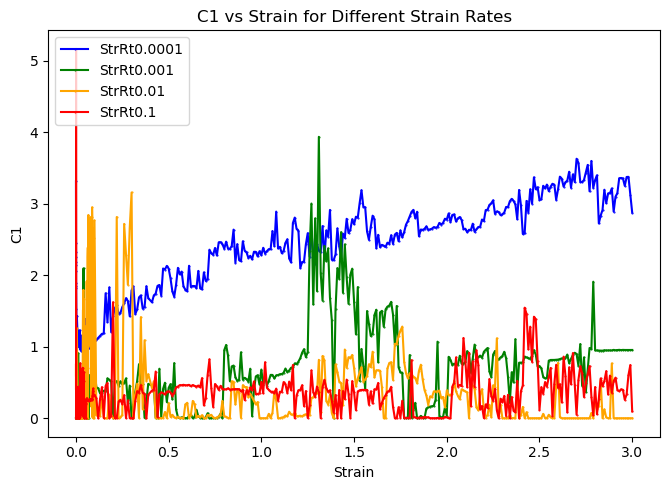

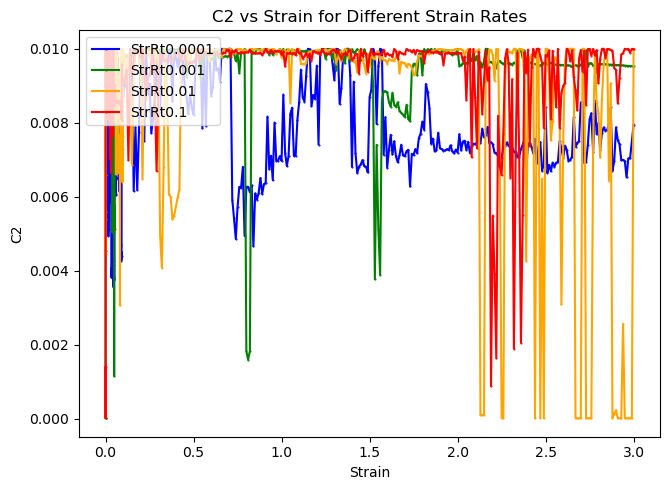

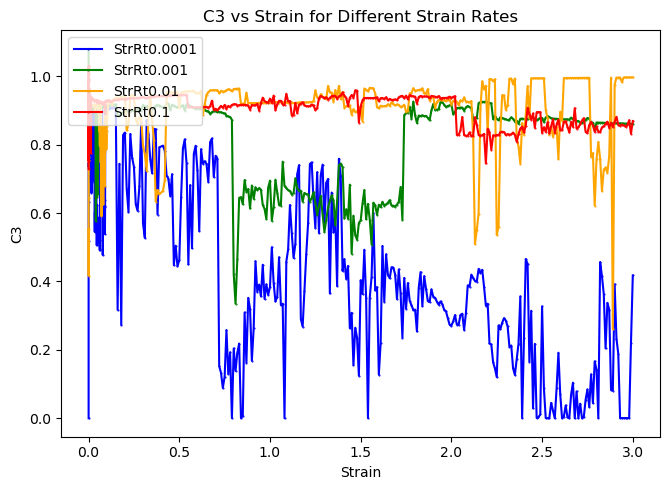

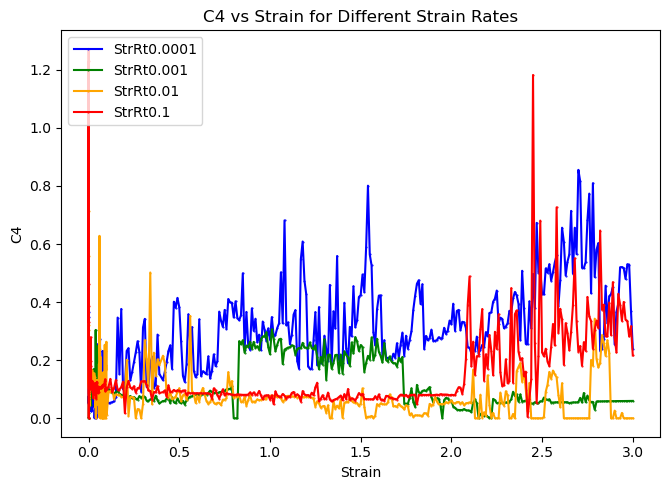

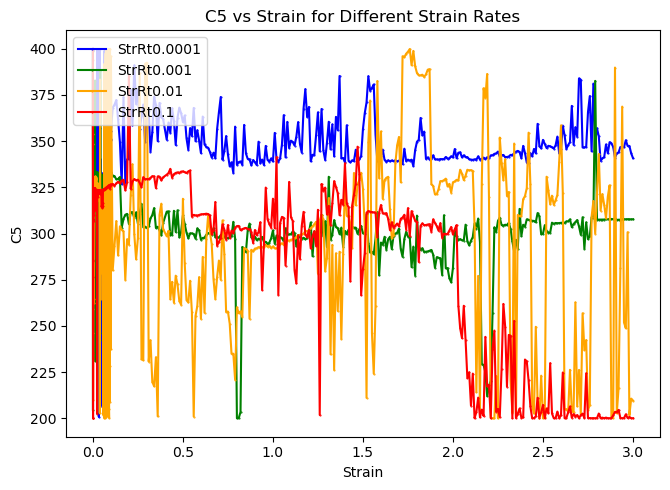

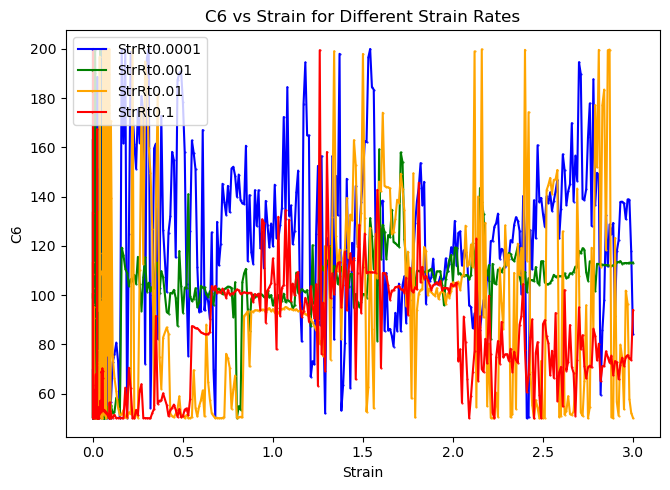

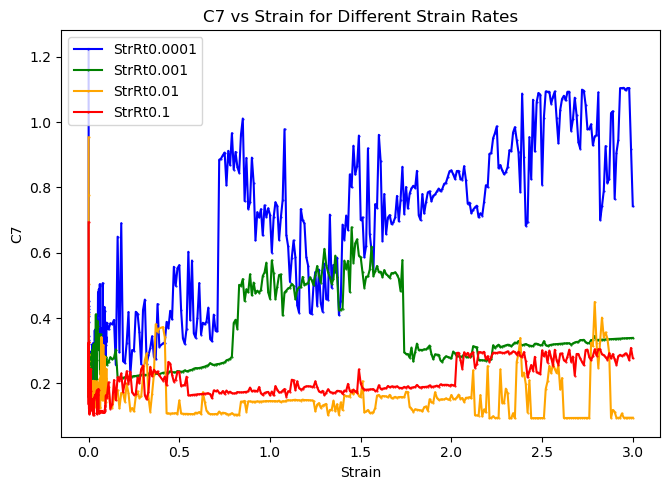

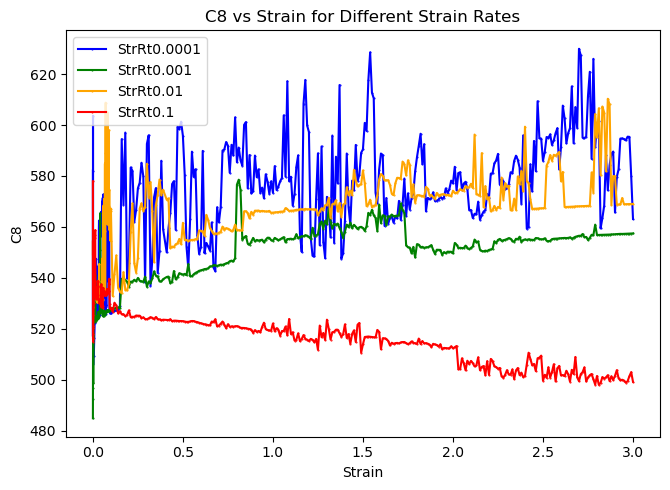

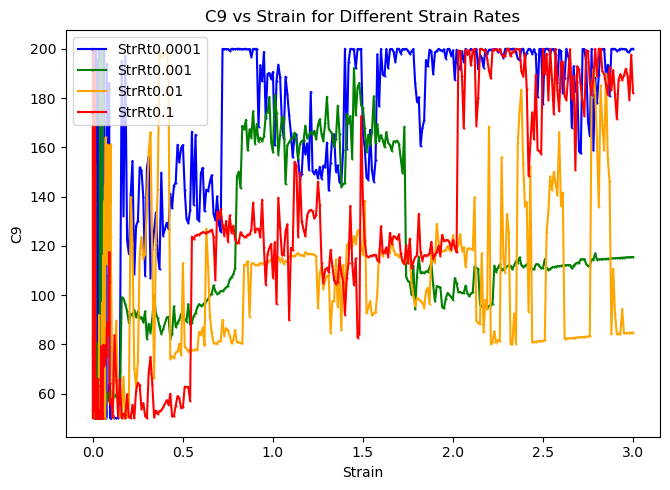

In [3]:
# List of files
files = [
    file_0001, file_001, file_01, file_1
]

# Specify the column names
x_column = 'PEEQ'
y_columns = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6','C7','C8','C9']

# Specify the PEEQ bounds
peeq_lower_bound = 0
peeq_upper_bound = 3

# Colors for different datasets
colors = ['blue', 'green', 'orange', 'red','black','purple','red','pink','brown']

# Iterate over each y-column
for y_column in y_columns:
    plt.figure(figsize=(8, 5))
    for file, color in zip(files, colors):
        # Read the data
        data = pd.read_csv(f"9_Parameters_{file}_results.csv")

        # Filter data based on the PEEQ bounds
        filtered_data = data[
            (data[x_column] > peeq_lower_bound) &
            (data[x_column] <= peeq_upper_bound) &
            (data[x_column] != 0.4)  # Exclude strain = 0.4
        ]
        
        label_name = file.split('_Str')[-1]  # Extract text after 'RD'
        # Plot the data for the current file
        plt.plot(
            filtered_data[x_column],
            filtered_data[y_column],
            marker='o',
            linestyle='-',
            markersize=0.5, 
            label=f'Str{label_name}',
            color=color
        )

    plt.xlabel('Strain')
    plt.ylabel(y_column)
    plt.title(f'{y_column} vs Strain for Different Strain Rates')
    #plt.legend(loc='upper right', bbox_to_anchor=(3.75, 3))
    #plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', frameon=True)
    plt.legend(loc='upper left')
    #plt.grid(True)
    #plt.tight_layout()
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

## Plot experimental data

In [10]:
# Load CSV files and extract relevant data
file_0001 = 'Fitted_FC_TmpDpn_RD_StrRt0.0001'
file_001 = 'Fitted_FC_TmpDpn_RD_StrRt0.001'
file_01 = 'Fitted_FC_TmpDpn_RD_StrRt0.01'
file_1 = 'Fitted_FC_TmpDpn_RD_StrRt0.1'

data_0001 = pd.read_csv(f"{file_0001}_ref.csv")
data_001 = pd.read_csv(f"{file_001}_ref.csv")
data_01 = pd.read_csv(f"{file_01}_ref.csv")
data_1 = pd.read_csv(f"{file_1}_ref.csv")

# Define strain indices
strain = np.array([2, 4, 10, 11, 14, 15, 20, 25, 30, 35, 40, 45, 50,65,105,115])

# Define temperature arrays for the x-axis
T1 = np.array([77.15, 233.15, 298.15, 373.15, 473.15, 573.15, 673.15])
T2 = np.array([298.15, 373.15, 473.15, 573.15, 673.15])

# Define colors for each strain rate
colors = {
    '0.0001': 'blue',
    '0.001': 'green',
    '0.01': 'orange',
    '0.1': 'red'
}

# Create a PDF to save the plots
output_pdf_path = "experimental_data_plots.pdf"
with PdfPages(output_pdf_path) as pdf_pages:
    # Iterate over each strain index and create a separate plot for each
    for i in strain:
        plt.figure(figsize=(8, 5))  # Create a new figure for each strain value
        #plt.ylim(0.8, 2)
        # Plot data points for each strain rate and connect them with lines
        if i < len(data_0001):
            rate_0001 = data_0001.iloc[i, 8:].values
            plt.plot(T1, rate_0001, 'o--', color=colors['0.0001'], label='Exp. Strain Rate 0.0001')  # Line and dots

        if i < len(data_001):
            rate_001 = data_001.iloc[i, 6:].values
            plt.plot(T2, rate_001, 's--', color=colors['0.001'], label='Exp. Strain Rate 0.001')  # Line and dots

        if i < len(data_01):
            rate_01 = data_01.iloc[i, 6:].values
            plt.plot(T2, rate_01, '^--', color=colors['0.01'], label='Exp. Strain Rate 0.01')  # Line and dots

        if i < len(data_1):
            rate_1 = data_1.iloc[i, 6:].values
            plt.plot(T2, rate_1, 'x--', color=colors['0.1'], label='Exp. Strain Rate 0.1')  # Line and dots

        # Customize the plot for each strain index
        plt.xlabel('Temperature (K)')
        plt.ylabel('Normalized Stress')
        
        plt.title(f'Strain = {data_0001.iloc[i, 0]:.5f}', fontweight='bold')  # Assuming PEEQ is in the first column of data_0001
        plt.legend(loc='best')

        # Save the current figure to the PDF
        pdf_pages.savefig()
        plt.close()  # Close the figure to save memory

print(f"All plots have been saved to '{output_pdf_path}'")

All plots have been saved to 'experimental_data_plots.pdf'
